<a href="https://colab.research.google.com/github/nika-va/practice/blob/main/04_transfer_learning_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Sep 25 12:26:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_red = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_red.extractall()
zip_red.close()

--2023-09-25 12:26:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.9MB/s    in 8.7s    

2023-09-25 12:26:17 (18.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os
for dir_path, dir_names, dir_files in os.walk('/content/10_food_classes_10_percent'):
  print(f' In {dir_path}, there are {len(dir_names)} directories, and {len(dir_files)} images')

 In /content/10_food_classes_10_percent, there are 2 directories, and 0 images
 In /content/10_food_classes_10_percent/test, there are 10 directories, and 0 images
 In /content/10_food_classes_10_percent/test/steak, there are 0 directories, and 250 images
 In /content/10_food_classes_10_percent/test/sushi, there are 0 directories, and 250 images
 In /content/10_food_classes_10_percent/test/ice_cream, there are 0 directories, and 250 images
 In /content/10_food_classes_10_percent/test/ramen, there are 0 directories, and 250 images
 In /content/10_food_classes_10_percent/test/grilled_salmon, there are 0 directories, and 250 images
 In /content/10_food_classes_10_percent/test/pizza, there are 0 directories, and 250 images
 In /content/10_food_classes_10_percent/test/fried_rice, there are 0 directories, and 250 images
 In /content/10_food_classes_10_percent/test/chicken_curry, there are 0 directories, and 250 images
 In /content/10_food_classes_10_percent/test/hamburger, there are 0 direct

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [5]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name +"/"+ experiment_name +'/'+ datetime.datetime.now().strftime('%Y%m%d')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

In [6]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'


def create_model(model_url, num_classes=10):
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = 'feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])
  return model

In [8]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [9]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics='accuracy')

In [11]:
tensorboard = create_tensorboard_callback('tensorflow_hub','resnet_50v2' )
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=tensorboard)

Saving TensorBoard log files to: tensorflow_hub/resnet_50v2/20230925
Epoch 1/5
24/24 [==============================] - 29s 560ms/step - loss: 1.8925 - accuracy: 0.3573 - val_loss: 1.2058 - val_accuracy: 0.6220
Epoch 2/5
24/24 [==============================] - 11s 490ms/step - loss: 0.8568 - accuracy: 0.7387 - val_loss: 0.8482 - val_accuracy: 0.7208
Epoch 3/5
24/24 [==============================] - 12s 500ms/step - loss: 0.5867 - accuracy: 0.8400 - val_loss: 0.7708 - val_accuracy: 0.7392
Epoch 4/5
24/24 [==============================] - 11s 492ms/step - loss: 0.4571 - accuracy: 0.8840 - val_loss: 0.7101 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 12s 492ms/step - loss: 0.3628 - accuracy: 0.9147 - val_loss: 0.6880 - val_accuracy: 0.7704


<Axes: >

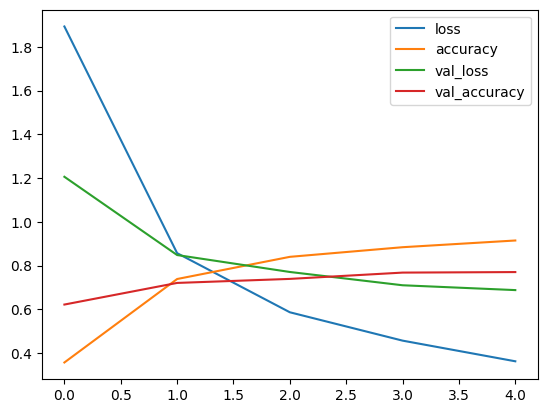

In [15]:
import pandas as pd
pd.DataFrame(resnet_history.history).plot()

In [119]:
import matplotlib.pyplot as plt

def plot_history_curves(history):
  """
  Plot model's history loss and the relavent metric curves seperately.
  """
  keys_names = list(resnet_history.history.keys())
  loss, metric, val_loss, val_metric = [resnet_history.history[key] for key in keys_names]
  epochs = range(len(history.history['loss']))

  plt.figure()
  plt.subplot(2,1,1)
  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss')
  plt.title('Loss curves')
  plt.xticks(epochs)
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(metric, label=keys_names[1])
  plt.plot(val_metric, label=keys_names[3])
  plt.title('Accuracy curves')
  plt.xticks(epochs)
  plt.legend()
  plt.tight_layout()

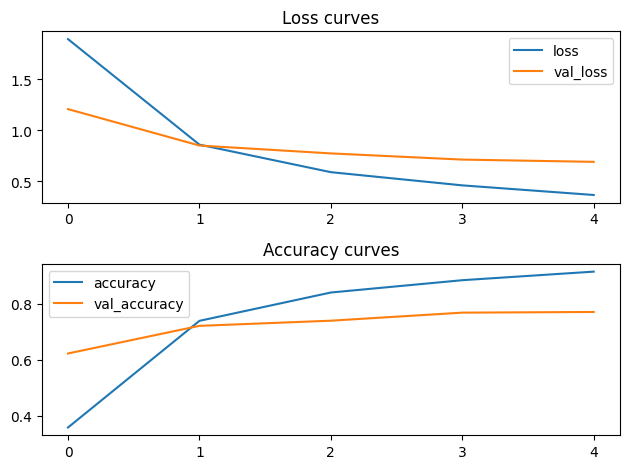

In [120]:
plot_history_curves(resnet_history)